In [1]:
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id

dl = DataSet(sample_in,sample_out,data_mode='sparse',data_ondisk=False)
dl.config = args
dl.initialize_data()
print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/simdata/simdata
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/simdata


In [2]:
model = np.load(sample_out+'_dcnmf.npz')

In [20]:
beta = model['beta']
theta = model['theta']
uu = beta.sum(0)
beta = beta/uu
prop = theta * uu
zz = prop.T.sum(0).reshape(theta.shape[0],1)
prop = prop/zz

df_beta = pd.DataFrame(beta.T)
df_beta.columns = dl.cols
df_theta = pd.DataFrame(prop)
df_theta.index = dl.rows

In [3]:
df_beta = pd.DataFrame(model['beta'].T)
df_beta.columns = dl.cols
df_theta = pd.DataFrame(model['corr'])
df_theta.index = dl.rows

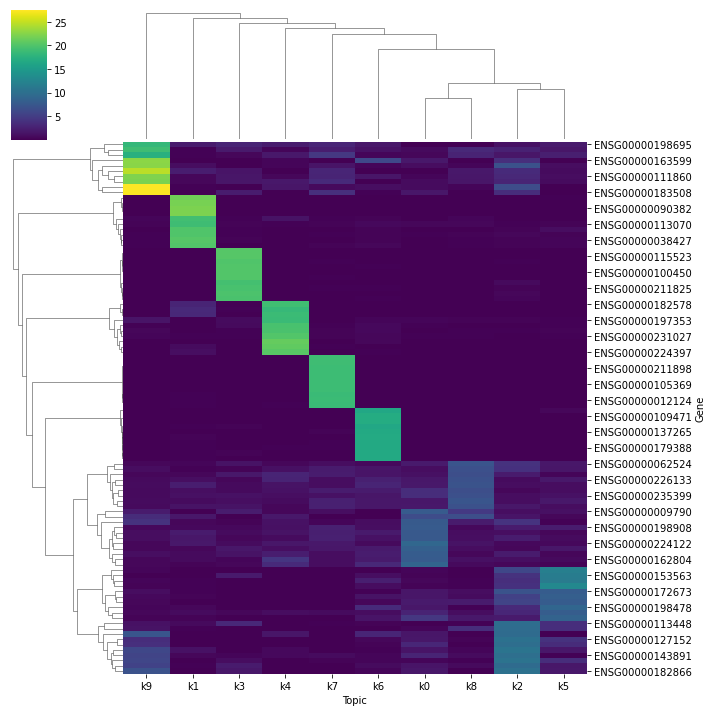

In [4]:
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>20] = 20
sns.clustermap(df_top.T,cmap='viridis')

In [5]:
import umap

df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.9,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

# df_umap = pd.read_csv(sample_out+'_theta_umap.csv')
# df_umap.columns = ['cell','umap1','umap2']


,cell,topic_bulk,umap1,umap2
0,"0_Monocyte,classical",1,21.105989,-0.139515
1,"1_Monocyte,classical",1,18.730684,1.069015
2,"2_Monocyte,classical",1,18.692064,-1.053721
3,"3_Monocyte,classical",1,18.145830,-0.734570
4,"4_Monocyte,classical",1,19.560049,-0.578851
...,...,...,...,...
9995,"995_Tcell,CD4,TH1/17",9,18.375193,7.131333
9996,"996_Tcell,CD4,TH1/17",9,13.882936,5.959834
9997,"997_Tcell,CD4,TH1/17",9,15.358868,6.791134
9998,"998_Tcell,CD4,TH1/17",9,14.653448,6.271509


Text(0, 0.5, 'UMAP2')

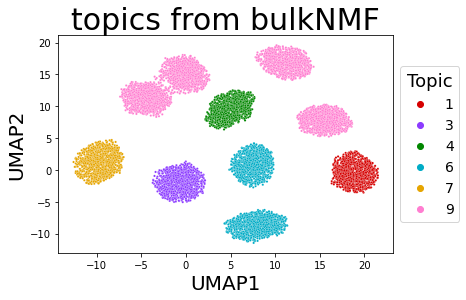

In [6]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

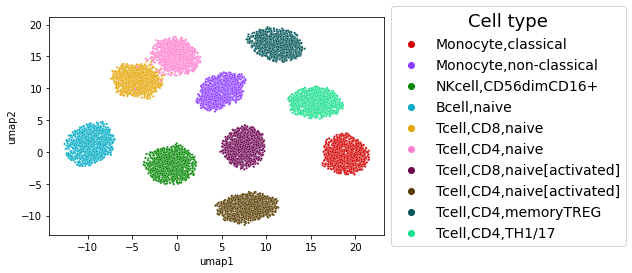

In [7]:
df_umap['cell_type'] = [x.split('_')[1] for x in df_umap['cell']]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=5,palette=cp,legend=True)
plt.legend(title='Cell type',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# p.axes.set_title("topics from bulkNMF",fontsize=30)
# p.set_xlabel("UMAP1",fontsize=20)
# p.set_ylabel("UMAP2",fontsize=20)

In [8]:
bulk_data = '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/resources/dice/mean_tpm_merged.csv.gz'
df_dice = pd.read_csv(bulk_data,compression='zip')

# remove non naive T cells
df_dice = df_dice[['gene', 
'Monocyte, classical',
'Monocyte, non-classical',
'NK cell, CD56dim CD16+',
'B cell, naive', 
'T cell, CD8, naive',
'T cell, CD4, naive',
'T cell, CD8, naive [activated]',
'T cell, CD4, naive [activated]',
'T cell, CD4, memory TREG', 
'T cell, CD4, TH1/17',
]]
df_dice = df_dice.set_index('gene').T

Text(224.82954545454544, 0.5, 'bulk')

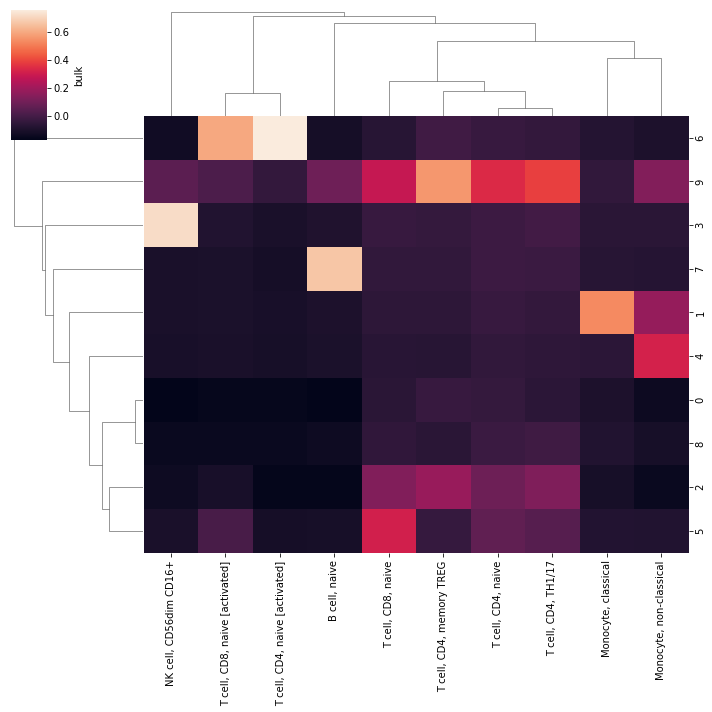

In [9]:
sel_top_genes = list(np.unique(topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)['Gene'].values))
K=10
corr=[]
for i in df_beta.index:
    cr = []
    for j in df_dice.index:
        cr.append(np.corrcoef(df_beta.loc[i,sel_top_genes],df_dice.loc[j,sel_top_genes])[0,1])
    corr.append(cr)

df_corr = pd.DataFrame(corr)
df_corr.index = df_beta.index
df_corr.columns = df_dice.index
sns.clustermap(df_corr)
plt.xlabel('sc')
plt.ylabel('bulk')

In [10]:
df_match = df_umap[['cell','cell_type','topic_bulk']]
df_match = df_match.groupby(['cell_type','topic_bulk']).count().reset_index()
df_match = df_match.pivot('cell_type','topic_bulk')
df_match = df_match.fillna(0)
df_match

cell                                        
topic_bulk                       1       3       4       6       7       9
cell_type                                                                 
Bcell,naive                    0.0     0.0     0.0     0.0  1000.0     0.0
Monocyte,classical          1000.0     0.0     0.0     0.0     0.0     0.0
Monocyte,non-classical         0.0     0.0  1000.0     0.0     0.0     0.0
NKcell,CD56dimCD16+            0.0  1000.0     0.0     0.0     0.0     0.0
Tcell,CD4,TH1/17               0.0     0.0     0.0     0.0     0.0  1000.0
Tcell,CD4,memoryTREG           0.0     0.0     0.0     0.0     0.0  1000.0
Tcell,CD4,naive                0.0     0.0     0.0     0.0     0.0  1000.0
Tcell,CD4,naive[activated]     0.0     0.0     0.0  1000.0     0.0     0.0
Tcell,CD8,naive                0.0     0.0     0.0     0.0     0.0  1000.0
Tcell,CD8,naive[activated]     0.0     0.0     0.0  1000.0     0.0     0.0

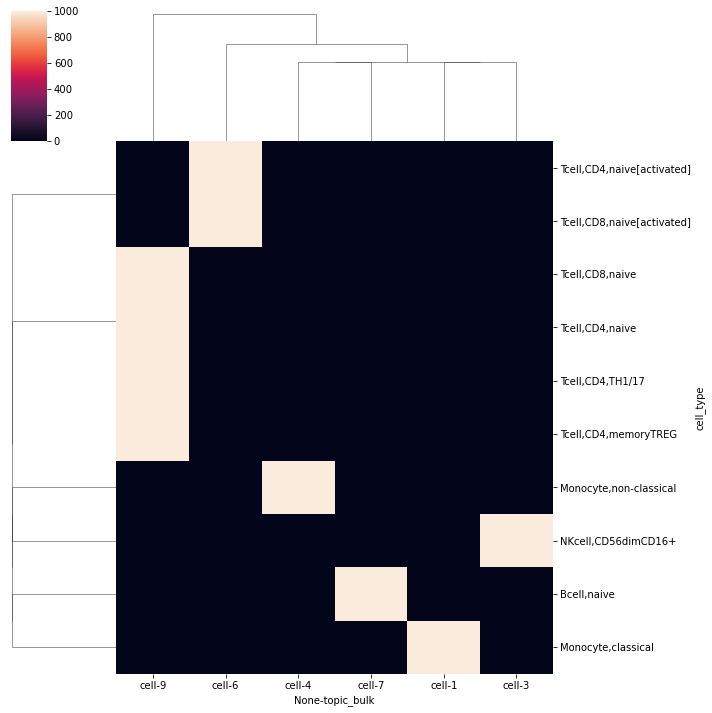

In [11]:
sns.clustermap(df_match)

In [12]:
df_match.values

array([[   0.,    0.,    0.,    0., 1000.,    0.],
       [1000.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0., 1000.,    0.,    0.,    0.],
       [   0., 1000.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0., 1000.],
       [   0.,    0.,    0.,    0.,    0., 1000.],
       [   0.,    0.,    0.,    0.,    0., 1000.],
       [   0.,    0.,    0., 1000.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0., 1000.],
       [   0.,    0.,    0., 1000.,    0.,    0.]])

In [13]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(df_umap['cell_type'].values,df_umap['topic_bulk'].values)

0.8228161798644423